# Clean HPS model with cross-validated subtyping
- take the full sample
- subsample using 10-fold cross-validation
- regress nuisance separately in the train and test fold
- extract subtypes on the train data
- extract weights for these subtypes from the train and test data
- predict easy cases on weights in train data
- predict ASD in test data using train data easy case signature
- report model performance

Other ideas:
- scale train data before nuisance regression
- then apply the fitted scaler to the test data before their nuisance regression?

In [1]:
%matplotlib inline

In [2]:
import os
import re
import sys
import time
import pickle
sys.path.append('/home/surchs/git/HPS')
from hps.predic import high_confidence
from hps.visu import hps_visu
sys.path.append('/home/surchs/git/HPS/examples/')
import warnings
warnings.filterwarnings('ignore')
import visu_demo
import scipy as sp
import patsy as pat
import numpy as np
import pandas as pd
import nibabel as nib
import sklearn as skl
import scipy.io as sio
import seaborn as sbn
import sklearn.metrics as skm
from scipy import cluster as scl
from scipy import stats as spt
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as sln
from sklearn import preprocessing as skp
from sklearn.model_selection import StratifiedKFold

In [1]:
n_seed = 12
n_subtypes = 4

In [2]:
# Paths
root_p = '/home/surchs/sim_big'
# Pheno
sample_p = os.path.join(root_p, 'PROJECT/abide_hps/pheno', 'psm_abide1.csv')
# Data
ct_p = os.path.join(root_p, 'PROJECT/abide_hps/ct')
seed_p = os.path.join(root_p, 'PROJECT/abide_hps/seed', 'MIST_{}'.format(n_seed))
mask_p = os.path.join(root_p, 'PROJECT/abide_hps/mask', 'MIST_mask.nii.gz')
label_p = os.path.join(root_p, 'ATLAS/MIST/Parcel_Information', 'MIST_{}.csv'.format(n_seed))
atlas_p = os.path.join(root_p, 'ATLAS/MIST/Parcellations/', 'MIST_{}.nii.gz'.format(n_seed))
# File templates
ct_t = '{}+{:07}_{}+{}_native_rms_rsl_tlaplace_30mm_{}.txt'
sd_t = 'sub_{{}}_mist_{}.npy'.format(n_seed)
# Make a temp save of the model
train_resid_p = os.path.join(root_p, 'PROJECT/abide_hps/train_resid_{{}}_{}.npy'.format(n_seed))
train_sbt_p = os.path.join(root_p, 'PROJECT/abide_hps/train_sbt_{{}}_{}.npz'.format(n_seed))
test_resid_p = os.path.join(root_p, 'PROJECT/abide_hps/test_resid_{{}}_{}.npy'.format(n_seed))
avg_dump_p = os.path.join(root_p, 'PROJECT/abide_hps/avg_dump_mist_{}_prereg_avg.p'.format(n_seed))#
out_p = os.path.join(root_p, 'PROJECT/abide_hps/ohbm_out_onlybrain')
if not os.path.isdir(out_p):
    os.makedirs(out_p)

NameError: name 'os' is not defined

In [5]:
# Load data
sample = pd.read_csv(sample_p)
sample['DX_CODE'] = sample['DX_GROUP'].replace({'Autism':1, 'Control':0})
label = pd.read_csv(label_p, delimiter=';')

In [6]:
sample.groupby('DX_GROUP').AGE_AT_SCAN.describe()

,count,mean,std,min,25%,50%,75%,max
DX_GROUP,,,,,,,,
Autism,182.0,16.987132,7.476016,7.13,11.335975,15.66000,19.688225,52.0
Control,188.0,16.879379,6.909948,6.47,11.765000,15.03265,21.110925,46.0


In [7]:
sample.groupby('DX_GROUP').FD_scrubbed.describe()

,count,mean,std,min,25%,50%,75%,max
DX_GROUP,,,,,,,,
Autism,182.0,0.171291,0.046925,0.074698,0.138477,0.163752,0.204446,0.377070
Control,188.0,0.171945,0.041957,0.079338,0.139670,0.167372,0.199710,0.277993


In [8]:
sample.groupby('DX_GROUP').SITE_ID.value_counts()

DX_GROUP  SITE_ID 
Autism    NYU         52
          USM         30
          UCLA_1      21
          KKI         16
          PITT        16
          TRINITY     15
          LEUVEN_1    11
          MAX_MUN      8
          YALE         7
          UM_1         6
Control   NYU         52
          USM         37
          UCLA_1      23
          TRINITY     17
          KKI         16
          PITT        16
          LEUVEN_1    10
          UM_1        10
          MAX_MUN      7
Name: SITE_ID, dtype: int64

In [9]:
sample.groupby('DX_GROUP')[['FIQ']].describe()

FIQ                                                         
          count        mean        std   min    25%    50%    75%    max
DX_GROUP                                                                
Autism    181.0  103.624309  17.299639  41.0   92.0  102.0  115.0  148.0
Control   187.0  111.871658  11.853365  81.0  104.0  111.0  119.0  146.0

In [10]:
mask_i = nib.load(mask_p)
mask = mask_i.get_data().astype(bool)
n_vox = np.sum(mask)
atlas = nib.load(atlas_p).get_data()

# Run the CV model

In [11]:
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

In [12]:
def subtype(stack, n_subtypes):
    # Normalize and then get the distance
    norm = skp.scale(stack, axis=1)
    # Get the lower triangle of the distance metric
    dist = sp.spatial.distance.pdist(norm)
    # Build the cluster
    link = scl.hierarchy.linkage(dist, method='ward')
    order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
    part = scl.hierarchy.fcluster(link, n_subtypes, criterion='maxclust')
    return order, part, dist

In [13]:
def regress_fc(sample, formula, n_vox, n_seed, seed_p, sd_t):
    n_sub = sample.shape[0]
    resid_seed = np.zeros((n_sub, n_vox, n_seed))
    dmat_seed = pat.dmatrix(formula, data=sample)
    for sid in range(n_seed):
        # Build the regression model for the seed maps
        mod = sln.LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
        sub_seed = np.zeros((n_sub, n_vox))
        # Line index doesn't necessarily match continuous index
        for rid, (rid_abs, row) in enumerate(sample.iterrows()):
            p = os.path.join(seed_p, sd_t.format(row['SUB_ID']))
            d = np.load(p)
            sub_seed[rid, :] = d[sid, ...]
        res = mod.fit(dmat_seed, sub_seed)
        resid = sub_seed - res.predict(dmat_seed)
        resid_seed[..., sid] = resid
    
    return resid_seed

In [14]:
def regress_ct(sample, formula, ct_p, ct_t):
    n_sub = sample.shape[0]
    # Generate the CT residuals
    for rid, (rid_abs, row) in enumerate(sample.iterrows()):
        p_right = os.path.join(ct_p, ct_t.format(row['Site'], row['Subject'], row['Session'], row['Run'], 'right'))
        p_left = os.path.join(ct_p, ct_t.format(row['Site'], row['Subject'], row['Session'], row['Run'], 'left'))
        ct_l = pd.read_csv(p_left, header=None)[0].values
        ct_r = pd.read_csv(p_right, header=None)[0].values
        # Combine left and right
        ct = np.concatenate((ct_l, ct_r))
        if rid==0:
            n_vert = len(ct)
            sub_ct = np.zeros((n_sub, n_vert))
        sub_ct[rid, :] = ct
    dmat_ct = pat.dmatrix(formula, data=sample)
    mod = sln.LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
    res = mod.fit(dmat_ct, sub_ct)
    resid_ct = sub_ct - res.predict(dmat_ct)
    
    return resid_ct, res

In [15]:
def make_subtype_fc(resid, n_subtypes=5):
    n_sub, n_vox, n_seed = resid.shape
    # Run the FC subtypes
    weights_fc = np.zeros((n_sub, n_subtypes, n_seed))
    subtypes_fc = np.zeros((n_subtypes,) + resid.shape[1:])
    parts_fc = np.zeros((n_sub, n_seed))
    orders_fc = np.zeros((n_sub, n_seed))
    dists_fc = np.zeros((n_sub, n_sub, n_seed))

    for sid in range(n_seed):
        order_fc, part_fc, dist_fc = subtype(resid[..., sid], n_subtypes)
        dists_fc[..., sid] = sp.spatial.distance.squareform(dist_fc)
        parts_fc[:, sid] = part_fc
        orders_fc[:, sid] = order_fc
        # Make the subtypes
        subtypes_fc_tmp = np.array([np.mean(resid[part_fc==i, :, sid], 0) 
                                    for i in range(1,n_subtypes+1)])
        subtypes_fc[..., sid] = subtypes_fc_tmp
        # Compute the weights
        weights_fc[..., sid] = corr2_coeff(resid[..., sid], subtypes_fc_tmp)
    return subtypes_fc, weights_fc

In [16]:
def make_subtype_ct(resid, n_subtypes):
    order_ct, part_ct, dist_ct = subtype(resid, n_subtypes)
    # Make the subtypes
    subtypes_ct = np.array([np.mean(resid[part_ct==i, :], 0) 
                            for i in range(1,n_subtypes+1)])
    # Compute the weights
    weights_ct = corr2_coeff(resid, subtypes_ct)
    return (subtypes_ct, weights_ct)

In [17]:
def make_weights_fc(subtypes, resid):
    n_sub, n_vox, n_seed = resid.shape
    n_subtypes = subtypes.shape[0]
    weights_fc = np.zeros((n_sub, n_subtypes, n_seed))
    for sid in range(n_seed):
    # Compute the weights
        weights_fc[..., sid] = corr2_coeff(resid[..., sid], subtypes[..., sid])
    return weights_fc

In [18]:
def make_weights_ct(subtypes, resid):
    weights_ct = corr2_coeff(resid, subtypes)
    return weights_ct

In [19]:
# Get the full range of subject indices and clinical labels
sub_indices = sample.index.values
labels = sample['DX_CODE'].values

In [20]:
fc_cols = ['fc_n{}_s{}'.format(nid+1, sid+1) 
           for sid in range(n_subtypes) 
           for nid in range(n_seed)]
fc_col_params = [(nid, sid) for sid in range(n_subtypes) 
                 for nid in range(n_seed)]

ct_cols = ['ct_s{}'.format(sid+1) 
           for sid in range(n_subtypes)]
ct_col_params = [(-1, sid) for sid in range(n_subtypes)]
cols = ct_cols + fc_cols
col_features = cols
col_params = ct_col_params + fc_col_params

In [21]:
scores_s1_l = list()
scores_s2_l = list()
y_target_l = list()

start = time.time()
took = []
skf = StratifiedKFold(n_splits=10)
for cv_idx, (train_index, test_index) in enumerate(skf.split(sub_indices, labels)):
    cv_start = time.time()
    
    train_p = train_resid_p.format(cv_idx)
    sbt_p = train_sbt_p.format(cv_idx)
    test_p = test_resid_p.format(cv_idx)
    
    # Get the train, and test sample
    train_sample = sample.loc[train_index]
    test_sample = sample.loc[test_index]
    n_sub_train = train_sample.shape[0]
    n_sub_test = test_sample.shape[0]
    
    # Replicate the subtyping process
    # Extract the train and test data and regress nuisance factors
    if not os.path.isfile(train_p):
        train_resid_fc = regress_fc(train_sample, 
                                   'AGE_AT_SCAN + FD_scrubbed + Site', 
                                   n_vox, n_seed=n_seed, 
                                   seed_p=seed_p, sd_t=sd_t)

        np.save(train_p, train_resid_fc)
    else:
        train_resid_fc = np.load(train_p)
        
    if not os.path.isfile(test_p):
        test_resid_fc = regress_fc(test_sample, 
                                  'AGE_AT_SCAN + FD_scrubbed + Site', 
                                  n_vox, n_seed=n_seed, 
                                  seed_p=seed_p, sd_t=sd_t)
        np.save(test_p, test_resid_fc)
    else:
        test_resid_fc = np.load(test_p)
        
    (train_resid_ct, mod_ct_train) = regress_ct(train_sample, 'AGE_AT_SCAN + Site', ct_p, ct_t)
    (test_resid_ct, mod_ct_test) = regress_ct(test_sample, 'AGE_AT_SCAN + Site', ct_p, ct_t)
    # Make the subtypes from the train data
    
    
    if not os.path.isfile(sbt_p):
        (subtypes_fc, train_weights_fc) = make_subtype_fc(train_resid_fc, n_subtypes=n_subtypes)
        np.savez(sbt_p, subtypes_fc=subtypes_fc, train_weights_fc=train_weights_fc)
    else:
        print('loading sbt from {}'.format(sbt_p))
        tmp = np.load(sbt_p)
        subtypes_fc = tmp['subtypes_fc']
        train_weights_fc = tmp['train_weights_fc']
    
    (subtypes_ct, train_weights_ct) = make_subtype_ct(train_resid_ct, n_subtypes=n_subtypes)
    # Get the test weights
    test_weights_fc = make_weights_fc(subtypes_fc, test_resid_fc)
    test_weights_ct = make_weights_ct(subtypes_ct, test_resid_ct)
    
    # Build input data
    train_fc = np.reshape(train_weights_fc, (n_sub_train, n_subtypes*n_seed))
    test_fc = np.reshape(test_weights_fc, (n_sub_test, n_subtypes*n_seed))
    train_w = np.concatenate((train_weights_ct, train_fc), 1)
    test_w = np.concatenate((test_weights_ct, test_fc), 1)
    
    # Make sure we use the correct index or else there will be NaNs in the weight columns
    w_data_train = pd.DataFrame(data=train_w, columns=cols, index=train_index)
    data_train = train_sample.join(w_data_train)
    w_data_test = pd.DataFrame(data=test_w, columns=cols, index=test_index)
    data_test = test_sample.join(w_data_test)
    
    # Select the features
    scaler = skl.preprocessing.StandardScaler()
    x_train = data_train.loc[:, col_features]
    # Normalize
    X_train = scaler.fit_transform(x_train)
    # Take the numeric diagnosis code, 0 is control, 1 is autism
    y_train = data_train.loc[:, ['DX_CODE']].values.squeeze()

    # Same for the test data
    x_test = data_test.loc[:, col_features]
    # Normalize, but use the fitted scalar of the training data
    X_test = scaler.transform(x_test)
    y_test = data_test.loc[:, ['DX_CODE']].values.squeeze()
    
    # Train the model
    hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=200,
                                          shuffle_test_split=0.5,
                                            gamma=1,
                                          min_gamma=0.98,
                                          thresh_ratio=0.8)
    hps.fit(X_train, y_train)
    scores, dic_results = hps.predict(X_test)
    scores_s1_l.append(dic_results['s1_hat'])
    scores_s2_l.append(dic_results['s2_hat'])
    y_target_l.append(y_test)

    current_duration = time.time()-cv_start
    took.append(current_duration)
    avg_time = np.mean(took)
    elapsed_time = np.sum(took)
    remaining_time = avg_time * (9-cv_idx)
    
    print('CV fold {} done. Took {:.2f}s ({:.2f}s), {:.2f}s total, {:.2f}s to go.'.format(cv_idx+1,
                                                                              current_duration,
                                                                              avg_time,
                                                                              elapsed_time,
                                                                              remaining_time))

loading sbt from /home/surchs/sim_big/PROJECT/abide_hps/train_sbt_0_12.npz
Stage 1
Stage 2
CV fold 1 done. Took 159.75s (159.75s), 159.75s total, 1437.72s to go.
loading sbt from /home/surchs/sim_big/PROJECT/abide_hps/train_sbt_1_12.npz
Stage 1
Stage 2
CV fold 2 done. Took 125.81s (142.78s), 285.56s total, 1142.23s to go.
loading sbt from /home/surchs/sim_big/PROJECT/abide_hps/train_sbt_2_12.npz
Stage 1
Stage 2
CV fold 3 done. Took 127.37s (137.64s), 412.93s total, 963.50s to go.
loading sbt from /home/surchs/sim_big/PROJECT/abide_hps/train_sbt_3_12.npz
Stage 1
Stage 2
CV fold 4 done. Took 146.78s (139.93s), 559.71s total, 839.57s to go.
loading sbt from /home/surchs/sim_big/PROJECT/abide_hps/train_sbt_4_12.npz
Stage 1
Stage 2
CV fold 5 done. Took 127.23s (137.39s), 686.94s total, 686.94s to go.
loading sbt from /home/surchs/sim_big/PROJECT/abide_hps/train_sbt_5_12.npz
Stage 1
Stage 2
CV fold 6 done. Took 122.51s (134.91s), 809.45s total, 539.64s to go.
loading sbt from /home/surchs/si

In [22]:
y = sample.DX_CODE.values.squeeze()

In [23]:
ohe = skl.preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

In [24]:
scores_s1_arr = np.vstack(scores_s1_l)
scores_s2_arr = np.vstack(scores_s2_l)
y_target_arr = np.hstack(y_target_l)

########################
print('##########################')
# S1
y_mb = ohe.transform(y_target_arr[:,np.newaxis])
pred_y_ = scores_s1_arr

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_))


# S2
y_mb = ohe.transform(y_target_arr[:,np.newaxis])
pred_y_ = scores_s2_arr

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_)) 
print('##########################')

##########################
Stage 1 (BASE)
Class 0 Precision: 58.12 Specificity: 56.04 Recall: 59.04 N: 191
Class 1 Precision: 56.98 Specificity: 59.04 Recall: 56.04 N: 179
Total Precision: 57.55 Specificity: 57.54 Recall: 57.54 N: 185
Stage 2 (HPS)
Class 0 Precision: 77.78 Specificity: 96.70 Recall: 11.17 N: 27
Class 1 Precision: 84.00 Specificity: 97.87 Recall: 11.54 N: 25
Total Precision: 80.89 Specificity: 97.29 Recall: 11.35 N: 26
##########################


In [25]:
hps_asd = scores_s2_arr[:, 1]==1
hps_con = scores_s2_arr[:, 1]==0
true_asd = y_mb[:, 1]==1
true_con = y_mb[:, 1]==0

In [59]:
# Save everything
# Save some of that data
cv_out = '/home/surchs/sim_big/PROJECT/abide_hps/ohbm_out_onlybrain/'
store_p = os.path.join(cv_out, 'cv_storage.npz')

In [60]:
np.savez(store_p, 
         y_target_cv=y_target_arr,
         scores_s1_arr=scores_s1_arr,
         scores_s2_arr=scores_s2_arr,
         y=y,
         hit_probability=hps.training_hit_probability)

In [26]:
sens = np.sum(hps_asd&true_asd)/np.sum(true_asd)

In [27]:
sens

0.11538461538461539

In [28]:
spec = np.sum(true_con[hps_con])/np.sum(true_con)

In [29]:
spec

0.9787234042553191

In [30]:
precision = np.sum(true_asd[hps_asd])/np.sum(hps_asd)

In [31]:
precision

0.84

In [32]:
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_mb[:, 1], scores_s2_arr[: , 1]).ravel().astype(float)

In [33]:
p = np.sum(y_mb[:, 1])
n = np.sum(y_mb[:, 0])

In [34]:
tpr = tp/p
fpr = fp/n

fnr = fn/p
tnr = tn/n

In [35]:
tpr/fpr

5.423076923076923

In [36]:
tnr/fnr

1.1063829787234043

In [37]:
fpr

0.02127659574468085

In [38]:
tpr

0.11538461538461539

In [39]:
fp

4.0

In [40]:
tp

21.0

In [41]:
fn

161.0

In [42]:
tn

184.0

In [43]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

In [44]:
accuracy

0.5540540540540541

In [45]:
# Save some of that data
cv_out = '/home/surchs/sim_big/PROJECT/abide_hps/ohbm_out_onlybrain/raw_figures/subtypes'

In [ ]:
hps_proba_single = hps.training_hit_probability[y==1]>0.98

In [52]:
hps.training_hit_probability

array([0.96116505, 0.90721649, 0.87962963, 1.        , 0.50549451,
       0.05940594, 0.88043478, 0.65      , 0.01923077, 0.98979592,
       0.59302326, 0.02884615, 0.62637363, 1.        , 0.68571429,
       0.70833333, 0.8       , 0.97029703, 0.93457944, 0.08163265,
       0.92631579, 0.34313725, 0.98039216, 0.37383178, 0.05208333,
       1.        , 0.98113208, 0.46153846, 0.67272727, 0.37931034,
       0.08411215, 0.7244898 , 0.98      , 0.55789474, 0.84693878,
       0.12264151, 0.01041667, 0.83870968, 0.08064516, 0.        ,
       0.82828283, 1.        , 0.59183673, 0.73786408, 0.12149533,
       0.01020408, 1.        , 0.04464286, 0.48695652, 1.        ,
       1.        , 0.98947368, 0.48113208, 0.88636364, 0.65656566,
       0.74468085, 0.02083333, 0.82524272, 0.08510638, 0.63207547,
       0.04672897, 0.62135922, 0.83333333, 1.        , 0.00934579,
       0.4953271 , 1.        , 1.        , 0.51401869, 0.39325843,
       1.        , 0.65048544, 0.16190476, 0.62244898, 0.78   

In [ ]:
f = plt.figure(figsize=(0.8, 78.74), constrained_layout=True)
ax = f.add_subplot(111)
ax.set_yticks([])
ax.set_xticks([])
ax.set_axis_off()
l_vec = np.zeros((2,1))
l_vec[0, 0] = 1
sbn.heatmap(clf_vec, linewidths=1, linecolor='white', ax=ax, cbar=False, cmap=sbn.xkcd_palette(['light grey', 'gold']))
for i in range(370):
    if i <150:
        ax.add_patch(mpatches.Rectangle((0,i),1,1,linewidth=3,edgecolor='blue',facecolor='none', clip_on=False))
    else:
        ax.add_patch(mpatches.Rectangle((0,i),1,1,linewidth=3,edgecolor='red',facecolor='none', clip_on=False))
f.savefig(os.path.join(cv_out, 'hps_class_vector.png'), dpi=200, transparent=True)

## Get the global average maps

In [ ]:
# CT
(resid_ct, mod_ct) = regress_ct(sample, 'AGE_AT_SCAN + Site', ct_p, ct_t)
ct_avg = mod_ct.coef_[:, 0]
ct_avg_l = ct_avg[:40962]
ct_avg_r = ct_avg[40962:]
# Save them
np.savetxt(os.path.join(out_p, 'ct_avg_left.txt'),ct_avg_l)
np.savetxt(os.path.join(out_p, 'ct_avg_right.txt'),ct_avg_r)

In [ ]:
# FC
if not os.path.isfile(avg_dump_p):
    n_sub = sample.shape[0]
    avg_fc = np.zeros((n_vox, n_seed))
    dmat_seed = pat.dmatrix('AGE_AT_SCAN + FD_scrubbed + Site', data=sample)
    for sid in range(n_seed):
        # Build the regression model for the seed maps
        mod = sln.LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
        sub_seed = np.zeros((n_sub, n_vox))
        sps = skp.StandardScaler()
        # Line index doesn't necessarily match continuous index
        for rid, (rid_abs, row) in enumerate(sample.iterrows()):
            p = os.path.join(seed_p, sd_t.format(row['SUB_ID']))
            d = np.load(p)
            sub_seed[rid, :] = d[sid, ...]
        sps.fit(sub_seed)
        avg_fc[:, sid] = sps.mean_
    np.save(avg_dump_p, avg_fc)
else:
    avg_fc = np.load(avg_dump_p)

## Train a model on the whole dataset

Stage 1
Stage 2


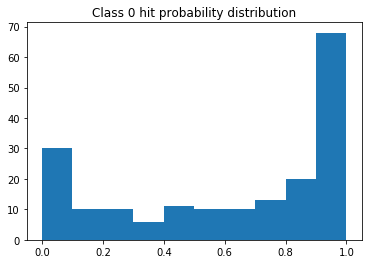

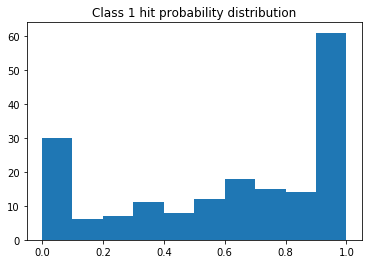

In [47]:
n_sub = sample.shape[0]

# Replicate the subtyping process
# Extract the train and test data and regress nuisance factors
resid_fc = regress_fc(sample, 
                           'AGE_AT_SCAN + FD_scrubbed + Site', 
                           n_vox, n_seed=n_seed, 
                           seed_p=seed_p, sd_t=sd_t)
(resid_ct, mod_ct) = regress_ct(sample, 'AGE_AT_SCAN + Site', ct_p, ct_t)

# Make the subtypes from the train data
(subtypes_fc, weights_fc) = make_subtype_fc(resid_fc, n_subtypes=n_subtypes)
(subtypes_ct, weights_ct) = make_subtype_ct(resid_ct, n_subtypes=n_subtypes)

# Build input data
fc = np.reshape(weights_fc, (n_sub, n_subtypes*n_seed))

features = np.concatenate((weights_ct, fc), 1)

# Make sure we use the correct index or else there will be NaNs in the weight columns
feat_data = pd.DataFrame(data=features, columns=cols)
data = sample.join(feat_data)

# Select the features
scaler = skl.preprocessing.StandardScaler()
x_ = data.loc[:, col_features]
# Normalize
X = scaler.fit_transform(x_)
# Take the numeric diagnosis code, 0 is control, 1 is autism
y = data.loc[:, ['DX_CODE']].values.squeeze()

# Train the model
hps = high_confidence.TwoStagesPrediction(verbose=False,
                                      n_iter=200,
                                      shuffle_test_split=0.5,
                                        gamma=1,
                                      min_gamma=0.98,
                                      thresh_ratio=0.8)

hps.fit(X, y)
x_ = data.loc[:, col_features]
# Normalize
X = scaler.fit_transform(x_)
# Take the numeric diagnosis code, 0 is control, 1 is autism
y = data.loc[:, ['DX_CODE']].values.squeeze()

res_hitproba = hps.training_hit_probability
plt.figure()
plt.title('Class 0 hit probability distribution')
plt.hist(hps.training_hit_probability[y==0],10);
plt.figure()
plt.title('Class 1 hit probability distribution')
plt.hist(hps.training_hit_probability[y==1],10);

In [48]:
hps_base_rate = np.sum(hps.training_hit_probability[y==1]>0.98)/len(hps.training_hit_probability[y==1])

In [49]:
hps_base_rate

0.1978021978021978

In [24]:
hps_base_rate*0.0113

0.003787362637362637

Assuming that our ASD sample was prevalent, how common would the identified subtype be in a general population sample? Answer: about 0.33% incidence. So not very large indeed. Bot on the other hand, they would make up 1/3 of individuals with ASD. So if we could push the base rate to 10% based on pre-screening or something like that:

In [25]:
hps_base_rate*0.1

0.033516483516483515

We'd already find about 3% of HPS cases in our screening sample. Not that many...

In [26]:
print('HPS base rate {:.2f}%'.format(hps_base_rate*100))

HPS base rate 33.52%


## Review the contributing FC features

In [123]:
# Get the feature weights of the second stage for class 2 (ASD)
feature_weights = hps.confidencemodel.clfs[1].coef_
non_zero_features = np.where(feature_weights!=0)[1]

In [124]:
f_dc = {key:list() for key in ['net', 'sid', 'weight', 'name', 'net_name', 'kind', 'nonzero', 'risk']}
for i in range(len(col_features)):
    f_name = col_features[i]
    if 'fc' in f_name:
        # FC
        net = col_params[i][0]
        sid = col_params[i][1]
        net_name = label.loc[label.roi==net+1].name.values[0]
        kind = 'FC'
    elif 'ct' in f_name:
        # CT
        net = None
        sid = col_params[i][1]
        net_name = None
        kind = 'CT'
    weight = feature_weights.flatten()[i]
    
    f_dc['net'].append(net)
    f_dc['sid'].append(sid)
    f_dc['weight'].append(weight)
    f_dc['name'].append(f_name)
    f_dc['net_name'].append(net_name)
    f_dc['kind'].append(kind)
    f_dc['nonzero'].append(weight!=0)
    f_dc['risk'].append(weight>0)
feature_data = pd.DataFrame(f_dc)
feature_nonzero = feature_data.loc[feature_data.nonzero]

In [125]:
f_sorted = feature_nonzero.sort_values(by=['net', 'sid'])
tmp_feat_sort_ind = f_sorted.index.values
f_sorted.reset_index(drop=True, inplace=True)

net_ind = list()
net_border = list()
lbl = list()
rbl = list()
for nid in range(n_seed):
    # Find the networks hits
    h_ind = f_sorted.loc[f_sorted.net==nid].index.values
    if not h_ind[0]-0.5 in net_border:
        net_border.append(h_ind[0]-0.5)
    net_border.append(h_ind[-1]+0.5)
    lbl.append( h_ind[0]-0.5)
    rbl.append( h_ind[-1]+0.5)
        
    if len(h_ind)<=2:
        net_ind.append(h_ind[0]+0.5)
    else:
        net_ind.append(h_ind[1])
# Add CT
#net_ind.append(33)
c_ind = np.array(net_ind)
b_ind = np.array(net_border)
lb = np.array(lbl)
rb = np.array(rbl)

In [127]:
from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

In [128]:
names = list(f_sorted.iloc[c_ind].net_name.values)
names.append('Cortical Thickness')

In [183]:
# Brain only model
# Re-order the networks so the effects don't overlap
new_net_order = ['MESOLIMBIC_NETWORK',
                 'BASAL_GANGLIA_and_THALAMUS',
                 'AUDITORY_NETWORK_and_POSTERIOR_INSULA',
                 'VISUAL_NETWORK',
                 'SOMATOMOTOR_NETWORK',
                 'DEFAULT_MODE_NETWORK_posteromedial',
                 'FRONTO_PARIETAL_NETWORK',
                 'CEREBELLUM',
                 'VENTRAL_VISUAL_STREAM_and_DORSAL_VISUAL_STREAM',
                 'DEFAULT_MODE_NETWORK_lateral',
                 'VENTRAL_ATTENTION_NETWORK_and_SALIENCE_NETWORK',
                 'DEFAULT_MODE_NETWORK_anteromedial_and_left_ANGULAR_GYRUS',
                 'Cortical Thickness']

In [184]:
net_ind_l = list()
# Get the FC indices for all subtypes
for i in new_net_order:
    for j in f_sorted.loc[f_sorted.net_name==i].index.values:
        net_ind_l.append(j)
# Add the CT indices for all subtypes
for j in f_sorted.loc[f_sorted.net_name.isnull()].index.values:
    net_ind_l.append(j)
new_net_ind = np.array(net_ind_l)

In [185]:
f_new_sorted = f_sorted.iloc[new_net_ind]
# Give CT a network name so we can use it like that as well
f_new_sorted.ix[f_new_sorted.kind=='CT', 'net_name'] = 'Cortical Thickness'
# Reset the index
f_new_sorted.reset_index(drop=False, inplace=True)

In [186]:
# Make new names again
net_ind_names = list()
net_border_names = list()
lbl_names = list()
rbl_names = list()
for n_name in new_net_order:
    # Find the networks hits
    h_ind = f_new_sorted.loc[f_new_sorted.net_name==n_name].index.values
    if not h_ind[0]-0.5 in net_border_names:
        net_border_names.append(h_ind[0]-0.5)
    net_border_names.append(h_ind[-1]+0.5)
    lbl_names.append( h_ind[0]-0.5)
    rbl_names.append( h_ind[-1]+0.5)
        
    if len(h_ind)<=2:
        net_ind_names.append(h_ind[0]+0.5)
    else:
        net_ind_names.append(h_ind[1])
# Add CT
#net_ind.append(33)
c_ind_names = np.array(net_ind_names)
b_ind_names = np.array(net_border_names)
lb_names = np.array(lbl_names)
rb_names = np.array(rbl_names)

In [187]:
asd_indices = sample.loc[y==1].index.values
hps_indices = asd_indices[np.where(hps.training_hit_probability[y==1]>0.95)]
nonhps_indices = asd_indices[np.where(hps.training_hit_probability[y==1]<=0.95)]
cond_arr = np.zeros(n_sub)
cond_arr[hps_indices] = 2
cond_arr[nonhps_indices] = 1

In [198]:
# Make the traces
features_all = data.loc[:, col_features].values
# Sort features to what I use in the rest of the plots
features_resort_like_others = features_all[:, tmp_feat_sort_ind]

feat_scaler = skl.preprocessing.StandardScaler()
features_all_scaled = feat_scaler.fit_transform(features_resort_like_others)
n_nonzero_features = features_resort_like_others.shape[1]
nonzero_feat_name = f_sorted.name.values
# Resort the features again according to the new networks

features_all_scaled_resorted = features_all_scaled[:, new_net_ind]
feat_names_resorted = list(nonzero_feat_name[new_net_ind])

trace_data = {'sub':[rid for rid, row in sample.iterrows() for fid in range(n_nonzero_features)],
              'cond':[cond_arr[rid] for rid, row in sample.iterrows() for fid in range(n_nonzero_features)],
              'weight':[features_all_scaled_resorted[rid, fid] for rid, row in sample.iterrows() for fid in range(n_nonzero_features)],
              'feat':[fid for rid, row in sample.iterrows() for fid in range(n_nonzero_features)]}
trace = pd.DataFrame(trace_data)
trace['condition'] = trace['cond'].replace({0:'CON', 1:'iASD', 2:'pASD'})

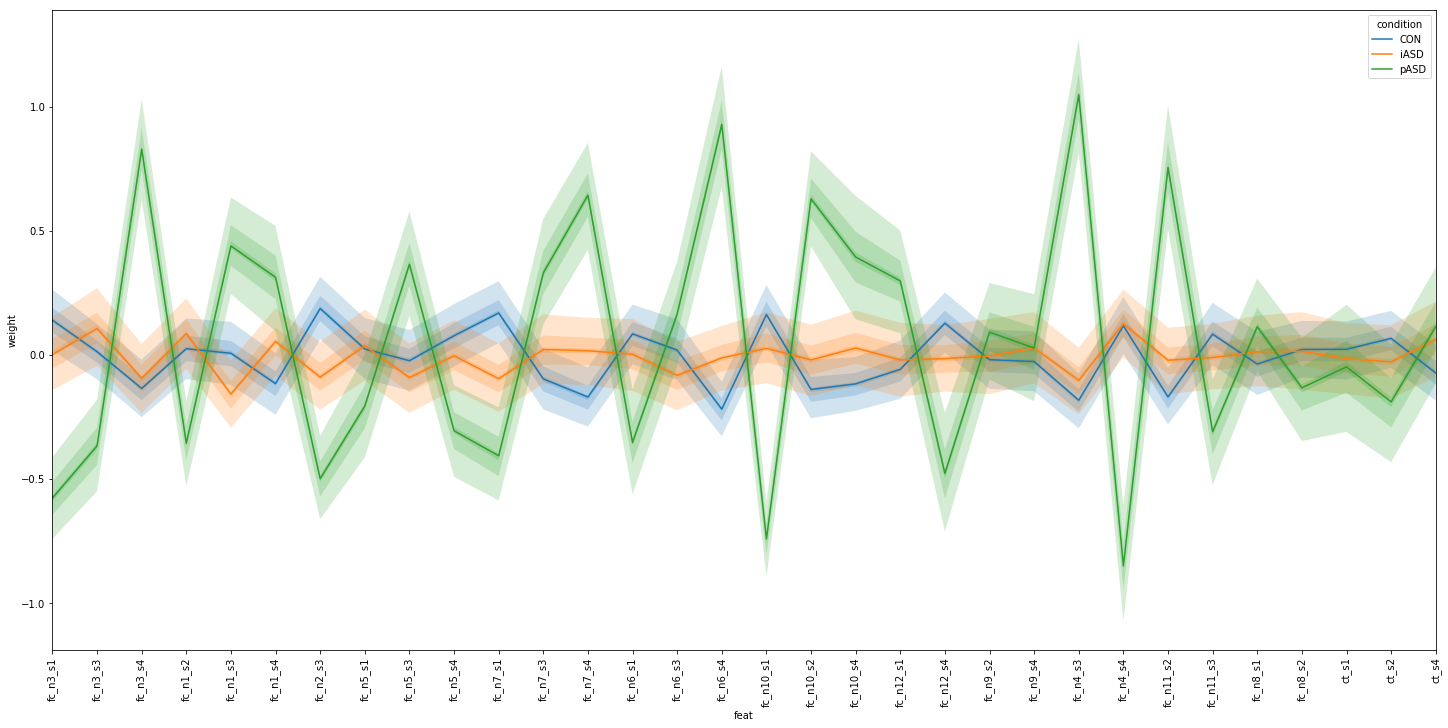

In [199]:
ff_names = [col_features[i] for i in non_zero_features[new_net_ind]]

f = plt.figure(figsize=(20,10), constrained_layout=True)
#ax = SubplotHost(f, 111)
ax = f.add_subplot(111)
qq = sbn.tsplot(time="feat", value="weight",
           unit="sub", condition="condition",data=trace, ci=[10,50,90], ax=ax)
ax.set_xticks(np.arange(n_nonzero_features))
ax.set_xticklabels(feat_names_resorted, rotation=90);

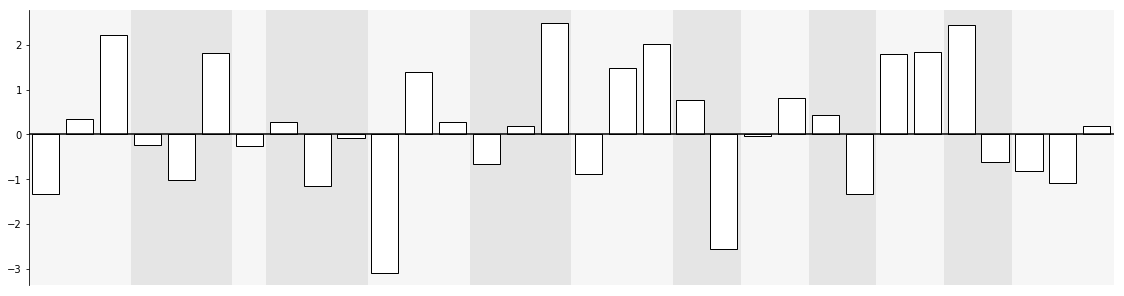

In [200]:
# Show the non-zero feature weights
f = plt.figure(figsize=(15.5,4), constrained_layout=True)
ax = f.add_subplot(111)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

for idx, (l, r) in enumerate(zip(lbl_names, rbl_names)):
    if idx%2==0:
        #ax.axvline(x=r, ymin=0.4, ymax=0.7, color='black')
        ax.axvspan(l, r, facecolor='lightgrey', alpha=0.2)
    else:
        #ax.axvline(x=r, ymin=0.4, ymax=0.7, color='black')
        ax.axvspan(l, r, facecolor='grey', alpha=0.2)
#ax.axvspan(28.5, 31.5, facecolor='lightgrey', alpha=0.2)

g = sbn.barplot(x='name', y='weight', data=f_sorted.iloc[new_net_ind], hue='kind', ax=ax, ci=None, dodge=False, 
                edgecolor="black", facecolor='white')
                #palette=sbn.xkcd_palette(['yellow orange', 'cerulean', 'light grey']), orient='v') #
    
ax.axhline(0, color='black')
ax.legend_.remove()

ax.set_xticks([]);
ax.set_xlabel('');
#ax.set_ylabel('Feature weight');
ax.set_ylabel('');
ax.set_xlim([-0.5, 31.5])

f.savefig(os.path.join(out_p, 'non-zero-features_horizontal.png'), dpi=300, transparent=True)

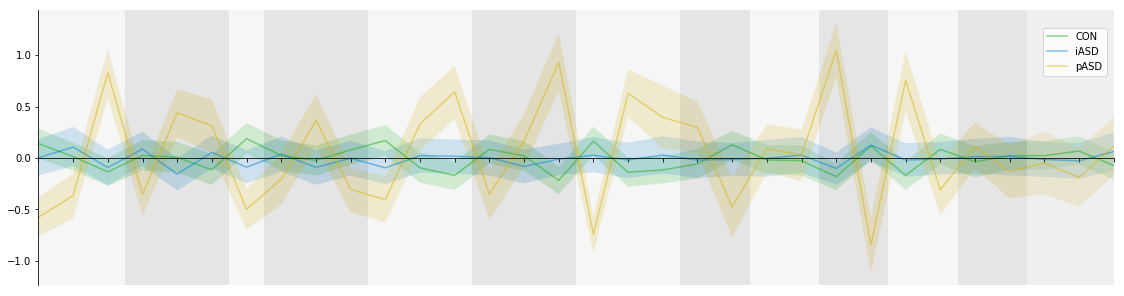

In [201]:
# Show the group trace only
f = plt.figure(figsize=(15.5,4), constrained_layout=True)
#ax = SubplotHost(f, 111)
ax = f.add_subplot(111)

ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)

for idx, (l, r) in enumerate(zip(lbl_names, rbl_names)):
    #ax.axvline(x=r, ymin=0.4, ymax=0.5, color='black')
    if idx%2==0:
        #ax.axvline(x=r, ymin=0.4, ymax=0.7, color='black')
        ax.axvspan(l, r, facecolor='lightgrey', alpha=0.2)
    else:
        #ax.axvline(x=r, ymin=0.4, ymax=0.7, color='black')
        ax.axvspan(l, r, facecolor='grey', alpha=0.2)
ax.axvspan(28.5, 31.5, facecolor='lightgrey', alpha=0.2)

#g = sbn.barplot(x='name', y='weight', data=f_sorted, hue='kind', ax=ax, ci=None, dodge=False, 
#                edgecolor="black", facecolor='white')

qq = sbn.tsplot(time="feat", value="weight",
           unit="sub", condition="condition",data=trace, ci=[95], ax=ax,
               color=sbn.xkcd_palette(['green', 'cerulean', 'gold']), alpha=0.5)


#ax.axhline(0, color='black')
#for i in b_ind:
#    ax.axvline(i, ymin=0.4, ymax=0.5, color='grey')
#new_axisline = ax2.get_grid_helper().new_fixed_axis
#ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax.legend_.remove()
ax.set_xticks(np.arange(n_nonzero_features));
ax.set_xticklabels([])
ax.set_xlabel('');
#ax.set_ylabel('Feature loading');
ax.set_ylabel('');
ax.legend(loc='center left', bbox_to_anchor=(0.93, 0.85))
#ax.set_xlim([-0.5, 31.5])

f.savefig(os.path.join(out_p, 'feature_trace_horizontal.png'), dpi=300, transparent=True)

(-1.7448223617882945, 1.4345315553936406)

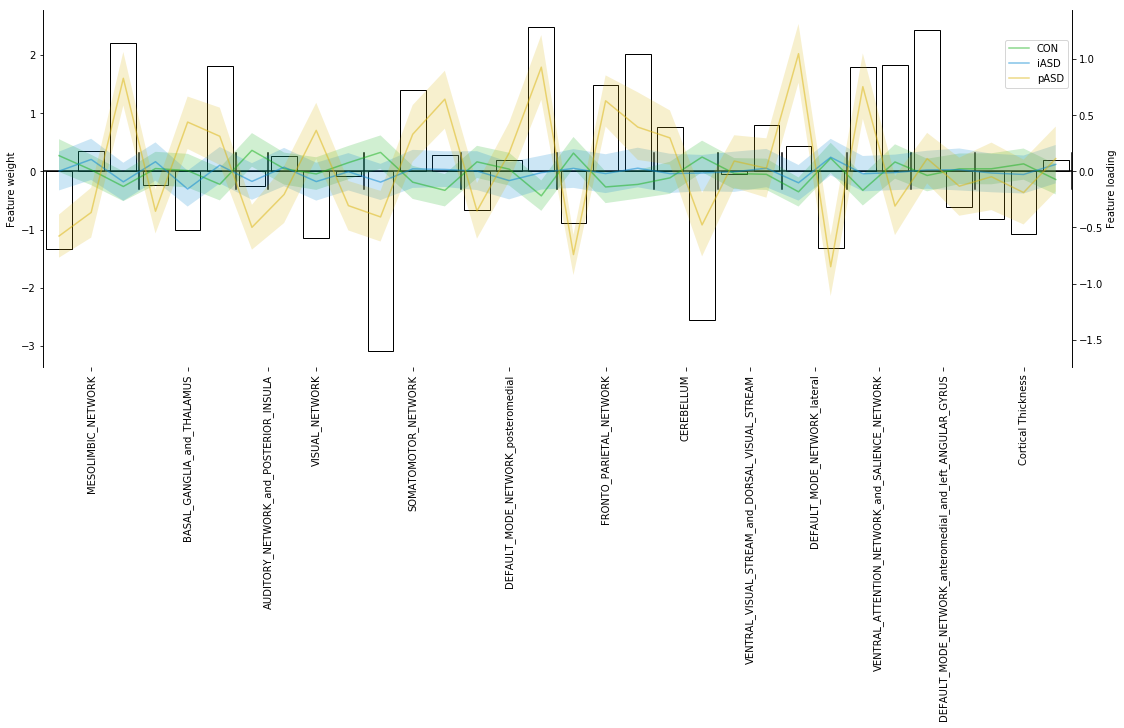

In [202]:
# Show all the non-zero data
#f = plt.figure(figsize=(15.5,4), constrained_layout=True)
f = plt.figure(figsize=(15.5,10), constrained_layout=True)
#ax = SubplotHost(f, 111)
ax = f.add_subplot(111)
ax2 = ax.twinx()

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

for idx, (l, r) in enumerate(zip(lbl_names, rbl_names)):
    ax.axvline(x=r, ymin=0.5, ymax=0.6, color='black')
    #if idx%2==0:
    #    ax.axvspan(l, r, facecolor='lightgrey', alpha=0.2)
    #else:
    #    ax.axvspan(l, r, facecolor='grey', alpha=0.2)
#ax.axvspan(28.5, 31.5, facecolor='lightgrey', alpha=0.2)
#ax.axvspan(36.5, 39.5, facecolor='grey', alpha=0.2)

#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='name', y='weight', data=f_new_sorted, hue='kind', ax=ax, ci=None, dodge=False, 
                edgecolor="black", facecolor='white')
                #palette=sbn.xkcd_palette(['yellow orange', 'cerulean', 'light grey']), orient='v') #
#g.set(xlabel='Feature Weights of HPS model', ylabel='')

qq = sbn.tsplot(time="feat", value="weight",
           unit="sub", condition="condition",data=trace, ci=[95], ax=ax2,
               color=sbn.xkcd_palette(['green', 'cerulean', 'gold']), alpha=0.5)
#ax.set_xticks(np.arange(n_nonzero_features))
#ax.set_xticklabels(feat_names_resorted, rotation=90);
#sbn.despine(bottom=True);

#ax.set_yticks(c_ind)
#ax.set_yticklabels(names, rotation=0)
ax.axhline(0, color='black')
#for i in b_ind:
#    ax.axvline(i, ymin=0.4, ymax=0.5, color='grey')
#new_axisline = ax2.get_grid_helper().new_fixed_axis
#ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax.legend_.remove()
ax.set_xticks(c_ind_names);
ax.set_xticklabels(new_net_order, rotation=90);
#ax.set_xticklabels([])
ax.set_xlabel('');
ax.set_ylabel('Feature weight');
ax2.set_ylabel('Feature loading');
ax2.legend(loc='center left', bbox_to_anchor=(0.93, 0.85))
ax.set_xlim([-0.5, 31.5])

# Bring to same scale
min_1, max_1 = ax.get_ylim()
range_1 = max_1-min_1

min_2, max_2 = ax2.get_ylim()
range_2 = max_2-min_2

new_range_2 = (max_2/max_1)*range_1
new_min_2 = max_2 - new_range_2
ax2.set_ylim([new_min_2, max_2])
# If needed

#f.savefig(os.path.join(out_p, 'non-zero-features_horizontal_combined.png'), dpi=300, transparent=True)

In [203]:
f_new_sorted.tail()

,index,net,sid,weight,name,net_name,kind,nonzero,risk
27,18,7.0,0,2.435464,fc_n8_s1,DEFAULT_MODE_NETWORK_anteromedial_and_left_ANG...,FC,True,True
28,19,7.0,1,-0.614435,fc_n8_s2,DEFAULT_MODE_NETWORK_anteromedial_and_left_ANG...,FC,True,False
29,29,NaN,0,-0.821285,ct_s1,Cortical Thickness,CT,True,False
30,30,NaN,1,-1.085378,ct_s2,Cortical Thickness,CT,True,False
31,31,NaN,3,0.197110,ct_s4,Cortical Thickness,CT,True,True


In [204]:
fc_data.tail()

,net,sid,weight,name,net_name,kind,nonzero,risk
38,10,2,1.829138,fc_n11_s3,VENTRAL_ATTENTION_NETWORK_and_SALIENCE_NETWORK,FC,True,True
49,9,3,2.013294,fc_n10_s4,FRONTO_PARIETAL_NETWORK,FC,True,True
42,2,3,2.210167,fc_n3_s4,MESOLIMBIC_NETWORK,FC,True,True
11,7,0,2.435464,fc_n8_s1,DEFAULT_MODE_NETWORK_anteromedial_and_left_ANG...,FC,True,True
45,5,3,2.488561,fc_n6_s4,DEFAULT_MODE_NETWORK_posteromedial,FC,True,True


In [205]:
fc_data = feature_data.loc[feature_data.kind=='FC']
fc_data.sort_values(by='weight', inplace=True)
fc_data[['net', 'sid']] = fc_data[['net', 'sid']].astype(int)

In [50]:
# How many networks are involved in the bottom 5 features
protective_fc = fc_data.iloc[:5]['net'].unique()

In [51]:
fc_data.iloc[:5]

,net,sid,weight,name,net_name,kind,nonzero,risk
10,6,0,-3.087141,fc_n7_s1,SOMATOMOTOR_NETWORK,FC,True,False
51,11,3,-2.546750,fc_n12_s4,CEREBELLUM,FC,True,False
6,2,0,-1.336447,fc_n3_s1,MESOLIMBIC_NETWORK,FC,True,False
43,3,3,-1.325575,fc_n4_s4,DEFAULT_MODE_NETWORK_lateral,FC,True,False
32,4,2,-1.151390,fc_n5_s3,VISUAL_NETWORK,FC,True,False


In [52]:
# How many networks are involved in the top 5 features
risk_fc = fc_data.iloc[::-1][:5]['net'].unique()

In [53]:
fc_data.iloc[::-1][:5]

,net,sid,weight,name,net_name,kind,nonzero,risk
45,5,3,2.488561,fc_n6_s4,DEFAULT_MODE_NETWORK_posteromedial,FC,True,True
11,7,0,2.435464,fc_n8_s1,DEFAULT_MODE_NETWORK_anteromedial_and_left_ANG...,FC,True,True
42,2,3,2.210167,fc_n3_s4,MESOLIMBIC_NETWORK,FC,True,True
49,9,3,2.013294,fc_n10_s4,FRONTO_PARIETAL_NETWORK,FC,True,True
38,10,2,1.829138,fc_n11_s3,VENTRAL_ATTENTION_NETWORK_and_SALIENCE_NETWORK,FC,True,True


In [ ]:
set(risk_fc).union(protective_fc)

In [ ]:
len(set(risk_fc).union(protective_fc))

In [ ]:
# Show me the top 5 features
for rid, (tmp, row) in enumerate(fc_data.iloc[::-1][:5].iterrows()):
    f = plt.figure(figsize=(8,4), constrained_layout=True)
    ax1 = f.add_subplot(111) 
    #ax2 = f.add_subplot(122)
    # Show me the subtype
    n_name = label.loc[label.roi==row['net']+1].name.values[0]
    vol = np.zeros(mask.shape)
    vol[mask] = subtypes_fc[row['sid'], :, row['net']]
    img = nib.Nifti1Image(vol, affine=mask_i.affine)
    
    a_vol = np.zeros(mask.shape)
    a_vol[atlas==row['net']+1] = 1
    a_img = nib.Nifti1Image(a_vol, affine=mask_i.affine)
    
    display = nlp.plot_stat_map(img, cut_coords=(0,0,0), axes=ax1, colorbar=False, draw_cross=False, cmap=plt.cm.RdBu_r)
    display.add_contours(a_img, levels=[.5], colors='black') 
    
    a_vol = np.zeros(mask.shape)
    a_vol[atlas==row['net']+1] = 1
    a_img = nib.Nifti1Image(a_vol, affine=mask_i.affine)
    f.savefig(os.path.join(out_p, 'fc_sbt_risk_{}_{}_{}.png'.format(rid, row['sid']+1, n_name)), dpi=300, transparent=True)

In [ ]:
# Show me the top 5 features
for rid, (tmp, row) in enumerate(fc_data.iloc[:5].iterrows()):
    f = plt.figure(figsize=(8,4), constrained_layout=True)
    ax1 = f.add_subplot(111) 
    #ax2 = f.add_subplot(122)
    # Show me the subtype
    n_name = label.loc[label.roi==row['net']+1].label.values[0]
    vol = np.zeros(mask.shape)
    vol[mask] = subtypes_fc[row['sid'], :, row['net']]
    img = nib.Nifti1Image(vol, affine=mask_i.affine)
    
    a_vol = np.zeros(mask.shape)
    a_vol[atlas==row['net']+1] = 1
    a_img = nib.Nifti1Image(a_vol, affine=mask_i.affine)
    
    display = nlp.plot_stat_map(img, cut_coords=(0,0,0), axes=ax1, colorbar=False, draw_cross=False, cmap=plt.cm.RdBu_r)
    display.add_contours(a_img, levels=[.5], colors='black') 
    
    a_vol = np.zeros(mask.shape)
    a_vol[atlas==row['net']+1] = 1
    a_img = nib.Nifti1Image(a_vol, affine=mask_i.affine)
    f.savefig(os.path.join(out_p, 'fc_sbt_protective_{}_{}_{}.png'.format(rid, row['sid']+1, n_name)), dpi=300, transparent=True)

## Save the average maps

In [ ]:
avg_fc.shape

In [ ]:
np.min(avg_fc, 1)

In [ ]:
for nid in range(n_seed):
    f = plt.figure(figsize=(8,4))
    ax1 = f.add_subplot(111) 
    #ax2 = f.add_subplot(122)
    # Show me the subtype
    n_name = label.loc[label.roi==nid+1].label.values[0]
    vol = np.zeros(mask.shape)
    vol[mask] = avg_fc[:, nid]
    img = nib.Nifti1Image(vol, affine=mask_i.affine)
    
    a_vol = np.zeros(mask.shape)
    a_vol[atlas==nid+1] = 1
    a_img = nib.Nifti1Image(a_vol, affine=mask_i.affine)
    
    display = nlp.plot_anat(cut_coords=(0,0,0), axes=ax1, draw_cross=False)
    display.add_overlay(img, cmap=plt.cm.viridis, colorbar=False, vmin=0)
    display.add_contours(a_img, levels=[.5], colors='black')
    f.savefig(os.path.join(out_p, 'fc_avg_{}.png'.format(n_name)), dpi=300, transparent=True)

In [ ]:
# Get the CT subtypes
for i in range(n_subtypes):
    ct_l = subtypes_ct[i, :40962]
    ct_r = subtypes_ct[i, :40962]
    np.savetxt(os.path.join(out_p, 'ct_{}_left.txt'.format(i)),ct_l)
    np.savetxt(os.path.join(out_p, 'ct_{}_right.txt'.format(i)),ct_r)

## Get best slice for network

In [ ]:
fc_data.loc[:4]

## Which are the features that are not zero

## Make the average positive feature (first 10)

In [ ]:
for i in sort_idx[:10]:
    print(col_params[i])

In [ ]:
pos_feat = np.zeros(subtypes_fc.shape[1])
q = 0
for i in sort_idx[-3:]:
    tmp = col_params[i]
    if feature_weights[:, i]<0:
        continue
    if tmp[0] is None:
        continue
    if tmp[0]<0:
        continue
    pos_feat += subtypes_fc[tmp[1], :, tmp[0]]
    q+=1
pos_feat = pos_feat/q


pos_vol = np.zeros(mask.shape)
pos_vol[mask] = pos_feat
pos_img = nib.Nifti1Image(pos_vol, affine=mask_i.affine)
nlp.plot_stat_map(pos_img, cut_coords=(0,0,0))

In [ ]:
feature_weights.shape

In [ ]:
neg_feat = np.zeros(subtypes_fc.shape[1])
q = 0
for i in sort_idx[:10]:
    tmp = col_params[i]
    if feature_weights[:, i]>0:
        continue
    if tmp[0] is None:
        continue
    if tmp[0]<0:
        continue
    neg_feat += subtypes_fc[tmp[1], :, tmp[0]]
    q+=1
neg_feat = neg_feat/q


neg_vol = np.zeros(mask.shape)
neg_vol[mask] = neg_feat
neg_img = nib.Nifti1Image(neg_vol, affine=mask_i.affine)
nlp.plot_stat_map(neg_img, cut_coords=(0,0,0))

## Attempt a validation

In [ ]:
y = sample.DX_CODE.values.squeeze()
ohe = skl.preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

In [ ]:
# Load data
validation_p = os.path.join(root_p, 'PROJECT/abide_hps/pheno', 'validation_abide1.csv')
validation = pd.read_csv(validation_p)
validation['DX_CODE'] = validation['DX_GROUP'].replace({'Autism':1, 'Control':0})
n_sub_valid = validation.shape[0]

In [ ]:
valid_resid_fc = regress_fc(validation, 
                            'AGE_AT_SCAN + FD_scrubbed + Site', 
                            n_vox, n_seed=n_seed, 
                            seed_p=seed_p, sd_t=sd_t)
(valid_resid_ct, valid_mod_ct) = regress_ct(validation, 'AGE_AT_SCAN + Site', ct_p, ct_t)
valid_weights_fc = make_weights_fc(subtypes_fc[0], valid_resid_fc)
valid_weights_ct = make_weights_ct(subtypes_ct[0], valid_resid_ct)

valid_fc = np.reshape(valid_weights_fc, (n_sub_valid, n_subtypes*n_seed))
valid_w = np.concatenate((valid_weights_ct, valid_fc), 1)

w_data_valid = pd.DataFrame(data=valid_w, columns=cols)
data_valid = validation.join(w_data_valid)

In [ ]:
x_valid = data_valid.loc[:, col_features]
X_valid = scaler.transform(x_valid)
y_valid = data_valid.loc[:, ['DX_CODE']].values.squeeze()

scores_valid, dic_results_valid = hps.predict(X_valid)

In [ ]:
scores_s1_valid = dic_results_valid['s1_hat']
scores_s2_valid = dic_results_valid['s2_hat']

In [ ]:
########################
print('##########################')
# S1
y_mb_valid = ohe.transform(y_valid[:,np.newaxis])
pred_y_valid = scores_s1_valid

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb_valid, pred_y_valid))


# S2
y_mb = ohe.transform(y_valid[:,np.newaxis])
pred_y_valid = scores_s2_valid

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb_valid, pred_y_valid)) 
print('##########################')

Well, that isn't so amazing now, is it? But it's also not worlds apart in terms of specificity. I mean the precision suffers greatly and overall the model doesn't appear that nice anymore. But it's not so horrible now.

In [ ]:
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_mb_valid[:, 1], scores_s2_valid[: , 1]).ravel().astype(float)

In [ ]:
tp

In [ ]:
fp

In [ ]:
tn

In [ ]:
fn

## Tell me something about these guys

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
HPS_ind_valid = pred_y_valid[:, 1]==1

In [ ]:
# Give me three classes here
asd_hps_valid = [True if HPS_ind_valid[rid]==1 and row['DX_GROUP']=='Autism' else False for rid, row in validation.iterrows()]
asd_ns_valid = [True if HPS_ind_valid[rid]==0 and row['DX_GROUP']=='Autism' else False for rid, row in validation.iterrows()]
tdc_hps_valid = [True if HPS_ind_valid[rid]==1 and row['DX_GROUP']=='Control' else False for rid, row in validation.iterrows()]
tdc_ns_valid = [True if HPS_ind_valid[rid]==0 and row['DX_GROUP']=='Control' else False for rid, row in validation.iterrows()]
group = list()
for rid, row in validation.iterrows():
    if asd_hps_valid[rid]:
        group.append('ASD_HPS')
    elif asd_ns_valid[rid]:
        group.append('ASD_NS')
    elif tdc_hps_valid[rid]:
        group.append('TDC_HPS')
    else:
        group.append('TDC_NS')
results_validation = validation.copy()
results_validation['Group'] = group
# Remove missing values
results_validation.replace({col:{-9999:None} for col in results_validation.columns}, inplace=True)

In [ ]:
sbn.barplot(x='Group', y='AGE_AT_SCAN', data=results_validation)

In [ ]:
sbn.barplot(x='Group', y='BV', data=results_validation)

In [ ]:
sbn.barplot(x='Group', y='FD_scrubbed', data=results_validation)

In [ ]:
sbn.barplot(x='Group', y='FIQ', data=results_validation)

In [ ]:
y_pred = scores_s2_arr
HPS_ind = y_pred[:, 1]==1

In [ ]:
# Give me three classes here
asd_hps = [True if HPS_ind[rid]==1 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
asd_ns = [True if HPS_ind[rid]==0 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
tdc = [True if row['DX_GROUP']=='Control' else False for rid, row in sample.iterrows()]
group = list()
for rid, row in sample.iterrows():
    if asd_hps[rid]:
        group.append('ASD_HPS')
    elif asd_ns[rid]:
        group.append('ASD_NS')
    else:
        group.append('TDC')
results = sample.copy()
results['Group'] = group
# Remove missing values
results.replace({col:{-9999:None} for col in results.columns}, inplace=True)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
sbn.barplot(x='Group', y='AGE_AT_SCAN', data=results)

In [ ]:
lm = ols('AGE_AT_SCAN ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

In [ ]:
sbn.barplot(x='Group', y='BV', data=results)

In [ ]:
lm = ols('BV ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

In [ ]:
sbn.barplot(x='Group', y='FD_scrubbed', data=results)

In [ ]:
lm = ols('FD_scrubbed ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

In [ ]:
sbn.barplot(x='Group', y='FIQ', data=results)

In [ ]:
sbn.barplot(x='Group', y='VIQ', data=results)

In [ ]:
sbn.barplot(x='Group', y='PIQ', data=results)

In [ ]:
sbn.barplot(x='Group', y='SRS_RAW_TOTAL', data=results)

In [ ]:
sbn.barplot(x='Group', y='Gotham_Severity', data=results)

In [ ]:
sbn.barplot(x='Group', y='HANDEDNESS_SCORES', data=results)

In [ ]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['DSM_IV_TR'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])